In [111]:
# Libraries Imports
#-----------------------------------------------------------------------------------------------------
from configparser import ConfigParser
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta


In [112]:
# Load connexion configuration file
#-----------------------------------------------------------------------------------------------------
config_filename = "./conf/GetWeather.ini"

# Read config.ini file
config_object = ConfigParser()
config_object.read(config_filename)
if  not config_object:
    print("Error while loading configuration !!!")

# Log initialization
cfg = config_object['INFO']

In [113]:
# Establish connection with DB (using sqlalchemy)
#-----------------------------------------------------------------------------------------------------
db_connection_str = "mysql+pymysql://{}:{}@{}/WeatherDB".format(cfg['user'],cfg['password'],cfg['host'])
db_connection = create_engine(db_connection_str)

In [ ]:
# Count sorted number of records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT Locations.name as name, COUNT(*) as nbRecords
FROM Records
INNER JOIN Locations ON Records.id_location = Locations.id
GROUP BY id_location
ORDER BY nbRecords DESC;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


In [ ]:
# Get average values on all records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT 
	    id_location, 
        Locations.name,
	    ROUND(AVG(pressure),2) AS avgPress,
	    ROUND(AVG(temp - 271.15),2) AS avgTemp,
	    ROUND(AVG(humidity),2) AS avgHumidity
    FROM Records
    INNER JOIN Locations on id_location = Locations.id
    GROUP BY id_location;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


In [ ]:
# Get minimum values per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
""" SELECT 
	    id_location, 
        Locations.name,
	    ROUND(MIN(pressure),2) AS MINPress,
	    ROUND(MIN(temp - 271.15),2) AS MINTemp,
	    ROUND(MIN(humidity),2) AS MINHumidity
    FROM Records
    Inner join Locations on id_location = Locations.id
    group by id_location;;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)

In [ ]:
# Hourly stats for a given day at a given location
#-----------------------------------------------------------------------------------------------------
my_date='2021-08-10'
loc = 6
raw_data = pd.read_sql(""" call Get_Hourly_Stats('{}',{});""".format(my_date, loc), con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(30)

In [ ]:
# Get hourly stats for a given range of day(s) and a single location
#-----------------------------------------------------------------------------------------------------
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# work variables for aggregation
start_date = date(2021,1,1)
end_date = date(2022,1,1)
loc = 6
pdata = pd.DataFrame([])
flagFirstRec = True
iter = 0

for my_date in daterange(start_date, end_date):
    iter += 1
    query = "call Get_Hourly_Stats('{}',{});".format(my_date, loc)
    raw_data = pd.read_sql(query, con=db_connection)
   
    if flagFirstRec:
        pdata = pd.DataFrame(raw_data)
        flagFirstRec = False
    else:
        pdata = pdata.append(pd.DataFrame(raw_data))
    
print("{} aggregate(s) created for a period of {} day(s).".format(pdata.shape,iter))

In [ ]:
#pdata.insert(0, 'idx', range(0,len(pdata)))
pdata.reset_index(drop=True)

In [ ]:
my_date = '2021-08-23'
loc = 6
query = "call Get_Monthly_Stats('{}',{});".format(my_date, loc)

pdata = pd.read_sql(query, con=db_connection)
pdata.rename(columns = {'date_timestamp':'timestamp'}, inplace = True)
pdata.insert(0,'id',0)
pdata.head(5)



In [91]:
pdata.to_sql('RecordsByHour', con=db_connection, if_exists='append',
           index=False)

In [ ]:
# TimeZone tools to get if measures are UTC/CET
from pytz import all_timezones
for timezone in all_timezones:
    print(timezone)

In [116]:
# Daily stats
#-----------------------------------------------------------------------------------------------------
queryDate = datetime.today().strftime('%Y-%m-%d')
#queryDate = '2021-09-03'
location = 6
raw_data = pd.read_sql(
"""
SELECT Locations.name, date_timestamp, hour(date_timestamp) as hour, (temp-273.15) as temp, pressure,humidity, clouds_cover, rain_1h, snow_1h 
FROM RawRecords
INNER JOIN Locations ON RawRecords.id_location = Locations.id
WHERE RawRecords.date_timestamp >= '{}' AND  RawRecords.id_location = {}
GROUP BY HOUR(date_timestamp)
ORDER BY HOUR(date_timestamp)
""".format(queryDate, location), con=db_connection)
pdata = pd.DataFrame(raw_data)
pdata.head(100)


,name,date_timestamp,hour,temp,pressure,humidity,clouds_cover,rain_1h,snow_1h


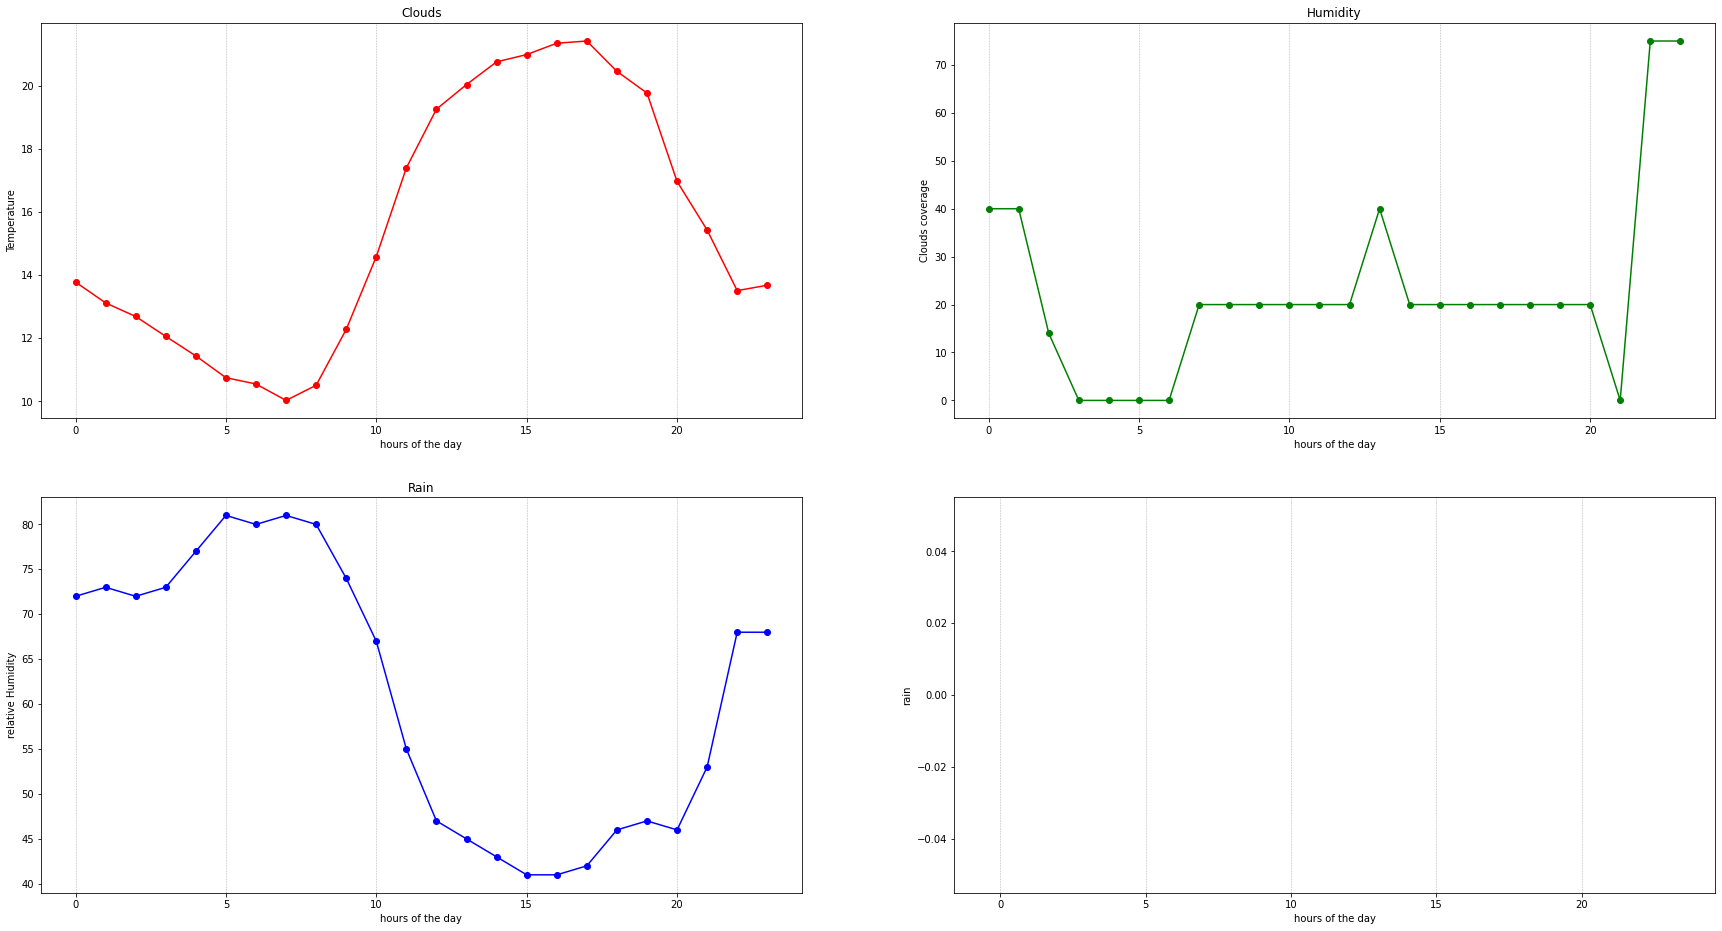

<Figure size 432x288 with 0 Axes>

In [115]:
# Set plot size
plt.figure(figsize=(30, 16))

# draw temp curve with pyplot
xpoints = raw_data['hour'].tolist()
ypoints = raw_data['temp'].tolist()

plt.subplot(2, 2, 1)
plt.title("Temperature")
plt.xlabel("hours of the day")
plt.ylabel("Temperature")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
display(plt.plot(xpoints, ypoints, 'o-r', linewidth=1.5))

# draw cloud cover percentage
ypoints = raw_data['clouds_cover'].tolist()
plt.title("Clouds")
plt.subplot(2, 2, 2)
plt.xlabel("hours of the day")
plt.ylabel("Clouds coverage")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.plot(xpoints, ypoints, 'o-g', linewidth=1.5)

# draw humidity cover percentage
ypoints = raw_data['humidity'].tolist()
plt.title("Humidity")
plt.subplot(2, 2, 3)
plt.xlabel("hours of the day")
plt.ylabel("relative Humidity")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.plot(xpoints, ypoints, 'o-b', linewidth=1.5)

# draw rain barchart
ypoints = raw_data['rain_1h'].tolist()
plt.title("Rain")
plt.subplot(2, 2, 4)
plt.xlabel("hours of the day")
plt.ylabel("rain")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.bar(xpoints,ypoints)
plt.show()
# Super title
plt.suptitle("Weather today")

# Show graphs
plt.show()

